## Google Earth Engine (GEE) Python API — Exercise
Using Sentinel2 - Level 2A, calculate the NDVI index averaged by year from 2018 to 2024 of a study area and export the image as average on the entire period.

### Connect to Google account

In [ ]:
import ee
# Trigger authentication in Colab
ee.Authenticate()
# Initialize with your project
ee.Initialize(project='ccgeo-480116')

### Define your study area and dates

In [ ]:
study_area = ee.Geometry.Polygon(
  [[[11.0, 45.0],
    [11.0, 44.5],
    [11.7, 44.5],
    [11.7, 45.0]]]
)

start_year = 2018
end_year = 2024

### Collect Sentinel 2 images

In [ ]:
s2_collection = (
  ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(study_area)
    .filterDate(ee.Date.fromYMD(start_year, 1, 1), ee.Date.fromYMD(end_year, 12, 31))
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
)

### Cloud mask for Sentinel-2 Level 1C using QA60 band

In [ ]:
def mask_s2_clouds(image):
    scl = image.select("SCL")
    nodata = scl.eq(0)
    saturated = scl.eq(1)
    dark_area = scl.eq(2)
    cloud_shadow = scl.eq(3)
    cloud_low = scl.eq(7)
    cloud_med = scl.eq(8)
    cloud_high = scl.eq(9)
    cloud_cirrus = scl.eq(10)

    cloud_mask = (
        cloud_shadow.add(cloud_low).add(cloud_med).add(cloud_high).add(cloud_cirrus)
        .add(nodata).add(saturated).add(dark_area)
    )

    invert_mask = cloud_mask.eq(0).selfMask()
    return image.updateMask(invert_mask)

def mask_water(image):
    scl = image.select("SCL")
    water = scl.eq(6)
    snow = scl.eq(11)
    mask = water.add(snow)
    invert_mask = mask.eq(0).selfMask()
    return image.updateMask(invert_mask)

### Add NDVI band: (NIR - RED) / (NIR + RED)

In [ ]:
def add_ndvi(image):
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")
    return image.addBands(ndvi)

### Apply cloud mask

In [ ]:
s2 = (
  s2_collection
    .map(mask_s2_clouds)
    .map(mask_water)
    .map(add_ndvi)
)

### Build a FeatureCollection of yearly mean NDVI

In [ ]:
years = ee.List.sequence(start_year, end_year)

def per_year(y):
  y = ee.Number(y)
  start = ee.Date.fromYMD(y, 1, 1)
  end = ee.Date.fromYMD(y, 12, 31)

  ndvi_year = s2.filterDate(start, end).select("NDVI")
  mean_ndvi_year = ndvi_year.mean().rename("NDVI")
  return mean_ndvi_year.set("system:time_start", y)

yearly_ndvi_ic = ee.ImageCollection(years.map(per_year))

### Plot the NDVI time-series of a point

In [ ]:
random_point_fc = ee.FeatureCollection.randomPoints(
  region=study_area,
  points=1,
  seed=42
)
random_point = ee.Feature(random_point_fc.first()).geometry()

In [ ]:
ts_fc = yearly_ndvi_ic.map(
  lambda img: ee.Feature(
      None,
      {
          "system:time_start": img.get("system:time_start"),
          "NDVI": img.reduceRegion(
              reducer=ee.Reducer.mean(),
              geometry=random_point,
              scale=10,
              maxPixels=1e9
          ).get("NDVI")
      }
  )
)

# Example: bring time series to client (prints a dict/list)
print("NDVI time series (per year at random point):")
print(ts_fc.getInfo())

NDVI time series (per year at random point):
{'type': 'FeatureCollection', 'columns': {}, 'features': [{'type': 'Feature', 'geometry': None, 'id': '0', 'properties': {'NDVI': 0.47376731038093567, 'system:time_start': 2018}}, {'type': 'Feature', 'geometry': None, 'id': '1', 'properties': {'NDVI': 0.5257344841957092, 'system:time_start': 2019}}, {'type': 'Feature', 'geometry': None, 'id': '2', 'properties': {'NDVI': 0.3837258517742157, 'system:time_start': 2020}}, {'type': 'Feature', 'geometry': None, 'id': '3', 'properties': {'NDVI': 0.4206089973449707, 'system:time_start': 2021}}, {'type': 'Feature', 'geometry': None, 'id': '4', 'properties': {'NDVI': 0.36359819769859314, 'system:time_start': 2022}}, {'type': 'Feature', 'geometry': None, 'id': '5', 'properties': {'NDVI': 0.34210124611854553, 'system:time_start': 2023}}, {'type': 'Feature', 'geometry': None, 'id': '6', 'properties': {'NDVI': 0.4223287105560303, 'system:time_start': 2024}}]}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert FeatureCollection to client-side dict
ts_info = ts_fc.getInfo()

# Extract year + NDVI
rows = []
for f in ts_info["features"]:
    props = f["properties"]
    rows.append({
        "year": int(props["system:time_start"]),
        "ndvi": props["NDVI"]
    })

df = pd.DataFrame(rows).sort_values("year")
print(df)

   year      ndvi
0  2018  0.473767
1  2019  0.525734
2  2020  0.383726
3  2021  0.420609
4  2022  0.363598
5  2023  0.342101
6  2024  0.422329


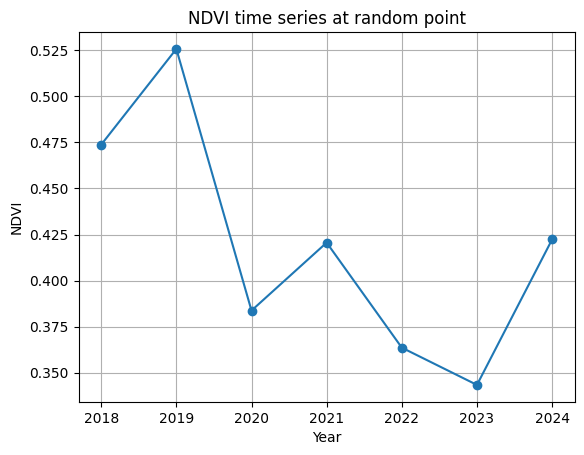

In [ ]:
plt.figure()
plt.plot(df["year"], df["ndvi"], marker="o")
plt.xlabel("Year")
plt.ylabel("NDVI")
plt.title("NDVI time series at random point")
plt.grid(True)
plt.show()

### Calculate the mean NDVI in the period

In [ ]:
mean_ndvi = s2.select("NDVI").mean().clip(study_area)

In [ ]:
import geemap

# Create interactive map
m = geemap.Map(center=[44.75, 11.35], zoom=9)

# NDVI visualization parameters
ndvi_vis = {
    "min": 0,
    "max": 1,
    "palette": [
        "#d73027", "#f46d43", "#fee08b",
        "#d9ef8b", "#66bd63", "#1a9850"
    ],
}

# Add layers
m.addLayer(mean_ndvi, ndvi_vis, "Mean NDVI (2018–2024)")
m.addLayer(study_area, {"color": "red"}, "Study Area")

# Display map
m

Map(center=[44.75, 11.35], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

### Export NDVI image to Google Drive

In [ ]:
export_task = ee.batch.Export.image.toDrive(
  image=mean_ndvi,
  description=f"Median_NDVI_S2_L1C_{start_year}_{end_year}",
  folder="GEE_exports",
  fileNamePrefix=f"median_ndvi_s2_l1c_{start_year}_{end_year}",
  region=study_area,
  scale=10,
  maxPixels=1e13
)

export_task.start()
print("Export started:", export_task.status())

Export started: {'state': 'READY', 'description': 'Median_NDVI_S2_L1C_2018_2024', 'priority': 100, 'creation_timestamp_ms': 1766734467636, 'update_timestamp_ms': 1766734467636, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'O7N4GMB7FLYGIQQF4RYFGSXI', 'name': 'projects/ccgeo-480116/operations/O7N4GMB7FLYGIQQF4RYFGSXI'}


### Calculate the regional mean and standard deviation in the study area of NDVI mean

In [ ]:
stats = mean_ndvi.reduceRegion(
  reducer=ee.Reducer.mean().combine(
      reducer2=ee.Reducer.stdDev(),
      sharedInputs=True
  ),
  geometry=study_area,
  scale=30,
  maxPixels=1e9
)

print("Stats (mean & stdDev) over study area:")
print(stats.getInfo())

Stats (mean & stdDev) over study area:
{'NDVI_mean': 0.46123864244986146, 'NDVI_stdDev': 0.12812912331633364}
